<a href="https://colab.research.google.com/github/samuel-oluwemimo/programming_pytorch_for_deep_learning/blob/main/R_V01_1_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN-Deep Learning

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from tqdm import tqdm

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [20]:
train = torchvision.datasets.CIFAR10(root='/content/', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='/content/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
test.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [22]:
class_labels = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [23]:
seed = 42
torch.manual_seed(seed)
train_size = round(0.9 * len(train))
train_set, val_set = torch.utils.data.random_split(train, [train_size,len(train)-train_size])

In [24]:
len(train), len(train_set), len(val_set)

(50000, 45000, 5000)

In [25]:
torch.manual_seed(seed)
batch_size = 32
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

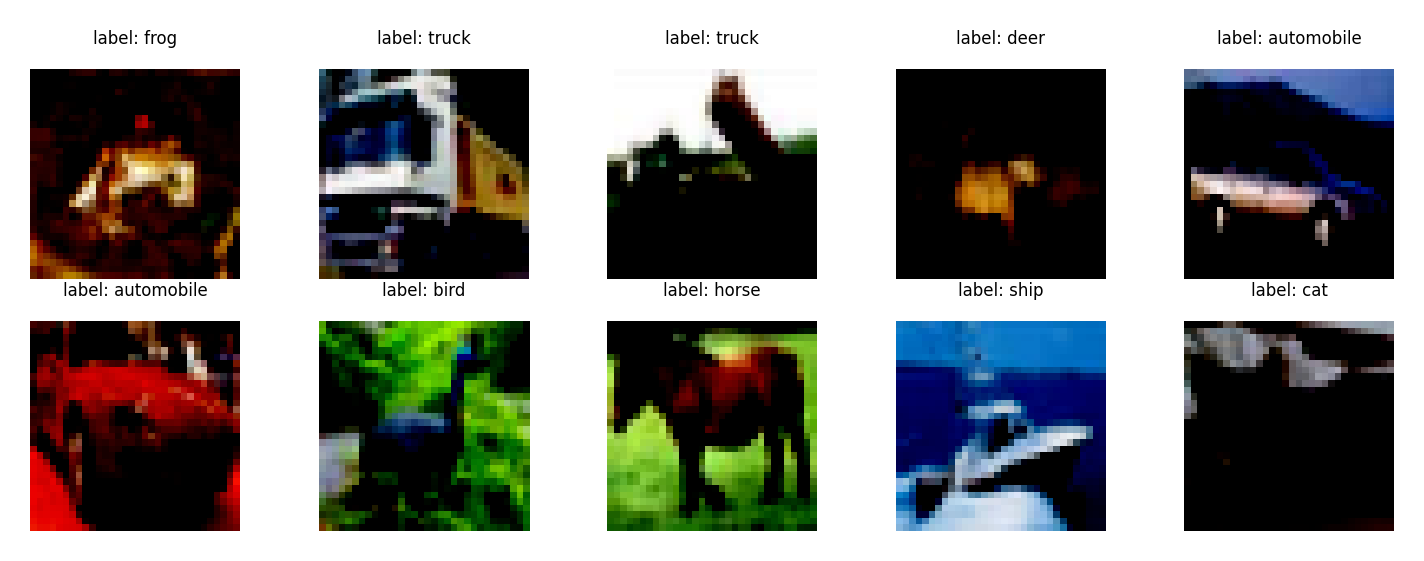

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=300, figsize=(6,2))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    image = train[i][0]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(f'label: {class_labels[train[i][1]]}', fontsize=4)
    plt.axis('off')
plt.show()


In [27]:
class ConvModel(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, stride=2, kernel_size=3, padding=2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(stride=2, kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, padding=2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(stride=2, kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, stride=2, kernel_size=3, padding=2),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(stride=2, kernel_size=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    self.fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(128*6*6, 512),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes),
    )

  def forward(self, x):
    x = self.conv(x)
    x  = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [28]:
model = ConvModel()

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [30]:
class EarlyStopping():
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif  val_loss > self.best_loss:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=6, verbose=True)

In [31]:
from tqdm import tqdm

def model_train(model, train_loader, val_loader, optimizer, loss_fn, epochs=50):
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct_train += (pred == labels).sum().item()
                total_train += len(labels)

                pbar.set_postfix(train_loss=train_loss/(total_train/len(labels)), train_accuracy=correct_train/total_train)
                pbar.update(1)

        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc=f"Validation {epoch}/{epochs}", unit="batch") as pbar:
                for images, labels in val_loader:
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, pred = torch.max(outputs, 1)
                    correct_val += (pred == labels).sum().item()
                    total_val += len(labels)

                    pbar.set_postfix(val_loss=val_loss/(total_val/len(labels)), val_accuracy=correct_val/total_val)
                    pbar.update(1)

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val

        print(f'Epoch: {epoch}, train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.2f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.2f}')
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print('Early Stopping')
            break


In [32]:
model_train(model, train_loader, test_loader, optimizer, loss_fn, epochs=50)

Validation 1/50: 100%|██████████| 313/313 [00:07<00:00, 39.30batch/s, val_accuracy=0.448, val_loss=0.763]


Epoch: 1, train_loss: 1.7329, train_accuracy: 0.35, val_loss: 1.5239, val_accuracy: 0.45


Validation 2/50: 100%|██████████| 313/313 [00:06<00:00, 45.72batch/s, val_accuracy=0.487, val_loss=0.71]


Epoch: 2, train_loss: 1.4856, train_accuracy: 0.46, val_loss: 1.4181, val_accuracy: 0.49


Validation 3/50: 100%|██████████| 313/313 [00:07<00:00, 40.57batch/s, val_accuracy=0.55, val_loss=0.633]


Epoch: 3, train_loss: 1.3585, train_accuracy: 0.51, val_loss: 1.2639, val_accuracy: 0.55


Validation 4/50: 100%|██████████| 313/313 [00:07<00:00, 44.49batch/s, val_accuracy=0.576, val_loss=0.598]


Epoch: 4, train_loss: 1.2685, train_accuracy: 0.55, val_loss: 1.1939, val_accuracy: 0.58


Validation 5/50: 100%|██████████| 313/313 [00:06<00:00, 44.98batch/s, val_accuracy=0.581, val_loss=0.599]


Epoch: 5, train_loss: 1.1903, train_accuracy: 0.59, val_loss: 1.1968, val_accuracy: 0.58


Validation 6/50: 100%|██████████| 313/313 [00:07<00:00, 41.39batch/s, val_accuracy=0.598, val_loss=0.578]


Epoch: 6, train_loss: 1.1327, train_accuracy: 0.60, val_loss: 1.1549, val_accuracy: 0.60


Validation 7/50: 100%|██████████| 313/313 [00:07<00:00, 40.43batch/s, val_accuracy=0.607, val_loss=0.565]


Epoch: 7, train_loss: 1.0828, train_accuracy: 0.63, val_loss: 1.1286, val_accuracy: 0.61


Validation 8/50: 100%|██████████| 313/313 [00:06<00:00, 45.79batch/s, val_accuracy=0.609, val_loss=0.564]


Epoch: 8, train_loss: 1.0340, train_accuracy: 0.64, val_loss: 1.1253, val_accuracy: 0.61


Validation 9/50: 100%|██████████| 313/313 [00:07<00:00, 40.34batch/s, val_accuracy=0.606, val_loss=0.578]


Epoch: 9, train_loss: 0.9938, train_accuracy: 0.66, val_loss: 1.1538, val_accuracy: 0.61


Validation 10/50: 100%|██████████| 313/313 [00:06<00:00, 45.25batch/s, val_accuracy=0.627, val_loss=0.555]


Epoch: 10, train_loss: 0.9620, train_accuracy: 0.67, val_loss: 1.1085, val_accuracy: 0.63


Validation 11/50: 100%|██████████| 313/313 [00:07<00:00, 39.55batch/s, val_accuracy=0.628, val_loss=0.555]


Epoch: 11, train_loss: 0.9255, train_accuracy: 0.68, val_loss: 1.1074, val_accuracy: 0.63


Validation 12/50: 100%|██████████| 313/313 [00:06<00:00, 44.77batch/s, val_accuracy=0.626, val_loss=0.547]


Epoch: 12, train_loss: 0.8992, train_accuracy: 0.69, val_loss: 1.0925, val_accuracy: 0.63


Validation 13/50: 100%|██████████| 313/313 [00:07<00:00, 40.22batch/s, val_accuracy=0.642, val_loss=0.544]


Epoch: 13, train_loss: 0.8651, train_accuracy: 0.70, val_loss: 1.0866, val_accuracy: 0.64


Validation 14/50: 100%|██████████| 313/313 [00:07<00:00, 44.12batch/s, val_accuracy=0.629, val_loss=0.553]


Epoch: 14, train_loss: 0.8410, train_accuracy: 0.71, val_loss: 1.1033, val_accuracy: 0.63


Validation 15/50: 100%|██████████| 313/313 [00:07<00:00, 41.32batch/s, val_accuracy=0.623, val_loss=0.565]


Epoch: 15, train_loss: 0.8155, train_accuracy: 0.72, val_loss: 1.1285, val_accuracy: 0.62


Validation 16/50: 100%|██████████| 313/313 [00:08<00:00, 38.59batch/s, val_accuracy=0.632, val_loss=0.571]


Epoch: 16, train_loss: 0.7919, train_accuracy: 0.72, val_loss: 1.1396, val_accuracy: 0.63


Validation 17/50: 100%|██████████| 313/313 [00:06<00:00, 45.24batch/s, val_accuracy=0.64, val_loss=0.559]


Epoch: 17, train_loss: 0.7671, train_accuracy: 0.73, val_loss: 1.1166, val_accuracy: 0.64


Validation 18/50: 100%|██████████| 313/313 [00:07<00:00, 40.10batch/s, val_accuracy=0.634, val_loss=0.581]


Epoch: 18, train_loss: 0.7472, train_accuracy: 0.74, val_loss: 1.1603, val_accuracy: 0.63


Validation 19/50: 100%|██████████| 313/313 [00:06<00:00, 45.54batch/s, val_accuracy=0.638, val_loss=0.582]

Epoch: 19, train_loss: 0.7274, train_accuracy: 0.75, val_loss: 1.1624, val_accuracy: 0.64
Early Stopping


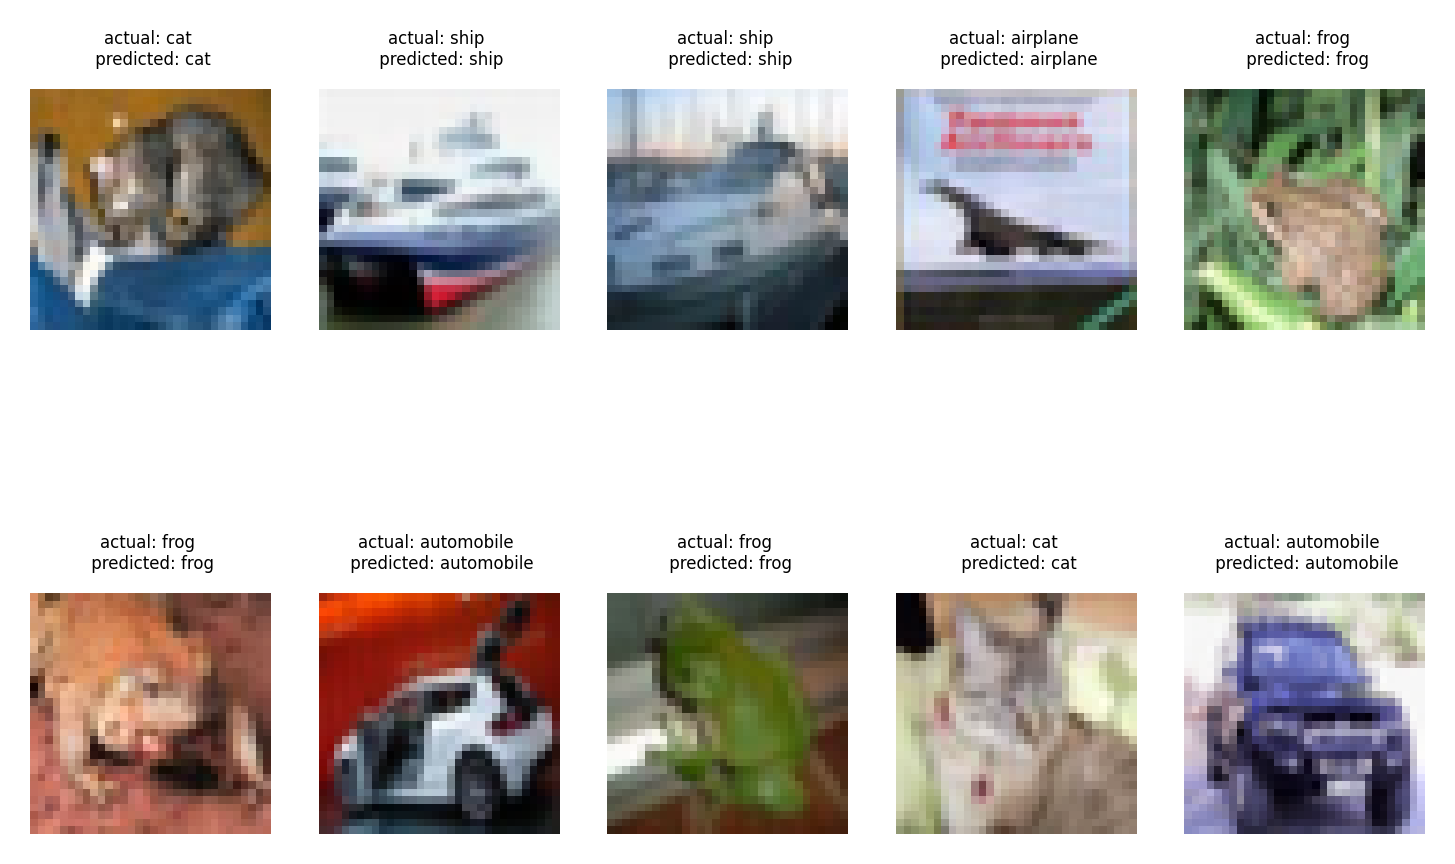

In [41]:
fig = plt.figure(dpi=300, figsize=(6,4))
for i in range(10):
    ax = plt.subplot(2,5, i+1)
    img = test[i][0].unsqueeze(0)
    label = test[i][1]
    pred = model(img)
    _, pred = torch.max(pred, 1)
    img = img.squeeze().permute(1,2,0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(f'actual: {class_labels[label]} \n predicted: {class_labels[pred]}', fontsize=4)
    plt.axis('off')
plt.show()